In [1]:
pip install pybbn

  Preparing metadata (setup.py) ... done
  Created wheel for pybbn: filename=pybbn-3.2.3-py3-none-any.whl size=40373 sha256=95f57dee13df949a8b8c67697c5b4564658551e56bf4e593403148583021e215
  Stored in directory: /root/.cache/pip/wheels/a7/6f/f1/ec7566a4882ab5c796fb43dfd84062769f75ba5381ca60d2b6
Successfully built pybbn


              Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  \
0       2008-12-01   Albury     13.4     22.9       0.6     5.469824   
1       2008-12-02   Albury      7.4     25.1       0.0     5.469824   
2       2008-12-03   Albury     12.9     25.7       0.0     5.469824   
3       2008-12-04   Albury      9.2     28.0       0.0     5.469824   
4       2008-12-05   Albury     17.5     32.3       1.0     5.469824   
...            ...      ...      ...      ...       ...          ...   
145454  2017-06-20    Uluru      3.5     21.8       0.0     5.469824   
145455  2017-06-21    Uluru      2.8     23.4       0.0     5.469824   
145456  2017-06-22    Uluru      3.6     25.3       0.0     5.469824   
145457  2017-06-23    Uluru      5.4     26.9       0.0     5.469824   
145458  2017-06-24    Uluru      7.8     27.0       0.0     5.469824   

        Sunshine WindGustDir  WindGustSpeed WindDir9am WindDir3pm  \
0       7.624853           W           44.0          W        WNW 

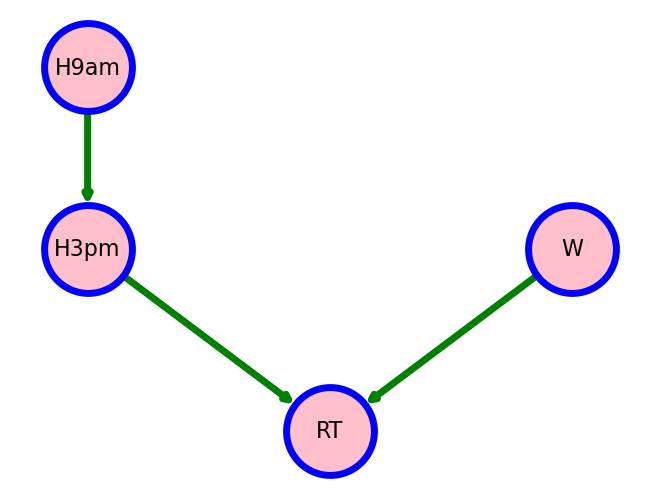

In [3]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from pybbn.graph.dag import Bbn
from pybbn.graph.edge import Edge, EdgeType
from pybbn.graph.jointree import EvidenceBuilder
from pybbn.graph.node import BbnNode
from pybbn.graph.variable import Variable
from pybbn.pptc.inferencecontroller import InferenceController

# Set Pandas options to display more columns
pd.options.display.max_columns = 50

# Read in the weather data csv
df = pd.read_csv('datasets/weatherAUS.csv', encoding='utf-8')

# Drop records where target RainTomorrow=NaN
df = df[pd.isnull(df['RainTomorrow']) == False]

# Select numeric columns for which you want to fill missing values with mean
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Fill missing values with mean for numeric columns only
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())

# Create bands for variables that we want to use in the model
df['WindGustSpeedCat'] = df['WindGustSpeed'].apply(lambda x: '0.<=40' if x <= 40 else '1.40-50' if 40 < x <= 50 else '2.>50')
df['Humidity9amCat'] = df['Humidity9am'].apply(lambda x: '1.>60' if x > 60 else '0.<=60')
df['Humidity3pmCat'] = df['Humidity3pm'].apply(lambda x: '1.>60' if x > 60 else '0.<=60')

# Show a snapshot of data
print(df)

# This function helps to calculate probability distribution, which goes into BBN (note, can handle up to 2 parents)
def probs(data, child, parent1=None, parent2=None):
    if parent1 == None:
        # Calculate probabilities
        prob = pd.crosstab(data[child], 'Empty', margins=False, normalize='columns').sort_index().to_numpy().reshape(
            -1).tolist()
    elif parent1 != None:
        # Check if the child node has 1 parent or 2 parents
        if parent2 == None:
            # Calculate probabilities
            prob = pd.crosstab(data[parent1], data[child], margins=False, normalize='index').sort_index().to_numpy().reshape(
                -1).tolist()
        else:
            # Calculate probabilities
            prob = pd.crosstab([data[parent1], data[parent2]], data[child], margins=False,
                               normalize='index').sort_index().to_numpy().reshape(-1).tolist()
    else:
        print("Error in Probability Frequency Calculations")
    return prob

# Create nodes by using our earlier function to automatically calculate probabilities
H9am = BbnNode(Variable(0, 'H9am', ['<=60', '>60']), probs(df, child='Humidity9amCat'))
H3pm = BbnNode(Variable(1, 'H3pm', ['<=60', '>60']), probs(df, child='Humidity3pmCat', parent1='Humidity9amCat'))
W = BbnNode(Variable(2, 'W', ['<=40', '40-50', '>50']), probs(df, child='WindGustSpeedCat'))
RT = BbnNode(Variable(3, 'RT', ['No', 'Yes']),
             probs(df, child='RainTomorrow', parent1='Humidity3pmCat', parent2='WindGustSpeedCat'))

# Create Network
bbn = Bbn() \
    .add_node(H9am) \
    .add_node(H3pm) \
    .add_node(W) \
    .add_node(RT) \
    .add_edge(Edge(H9am, H3pm, EdgeType.DIRECTED)) \
    .add_edge(Edge(H3pm, RT, EdgeType.DIRECTED)) \
    .add_edge(Edge(W, RT, EdgeType.DIRECTED))

# Convert the BBN to a join tree
join_tree = InferenceController.apply(bbn)

# Set node positions
pos = {0: (-1, 2), 1: (-1, 0.5), 2: (1, 0.5), 3: (0, -1)}

# Set options for graph looks
options = {
    "font_size": 16,
    "node_size": 4000,
    "node_color": "pink",
    "edgecolors": "blue",
    "edge_color": "green",
    "linewidths": 5,
    "width": 5,
}

# Generate graph
n, d = bbn.to_nx_graph()
nx.draw(n, with_labels=True, labels=d, pos=pos, **options)

# Update margins and print the graph
ax = plt.gca()
ax.margins(0.10)
plt.axis("off")
plt.show()
